# Figure 9 LFE Percentage Power Figure
In this notebook we will demonstrate code to produce a figure showing the percentage of the total integrated power that is the LFE
## Load LFE Flimits

## Create Figure

Text(0.5, 0.03, 'Substorm Epoch [min]')

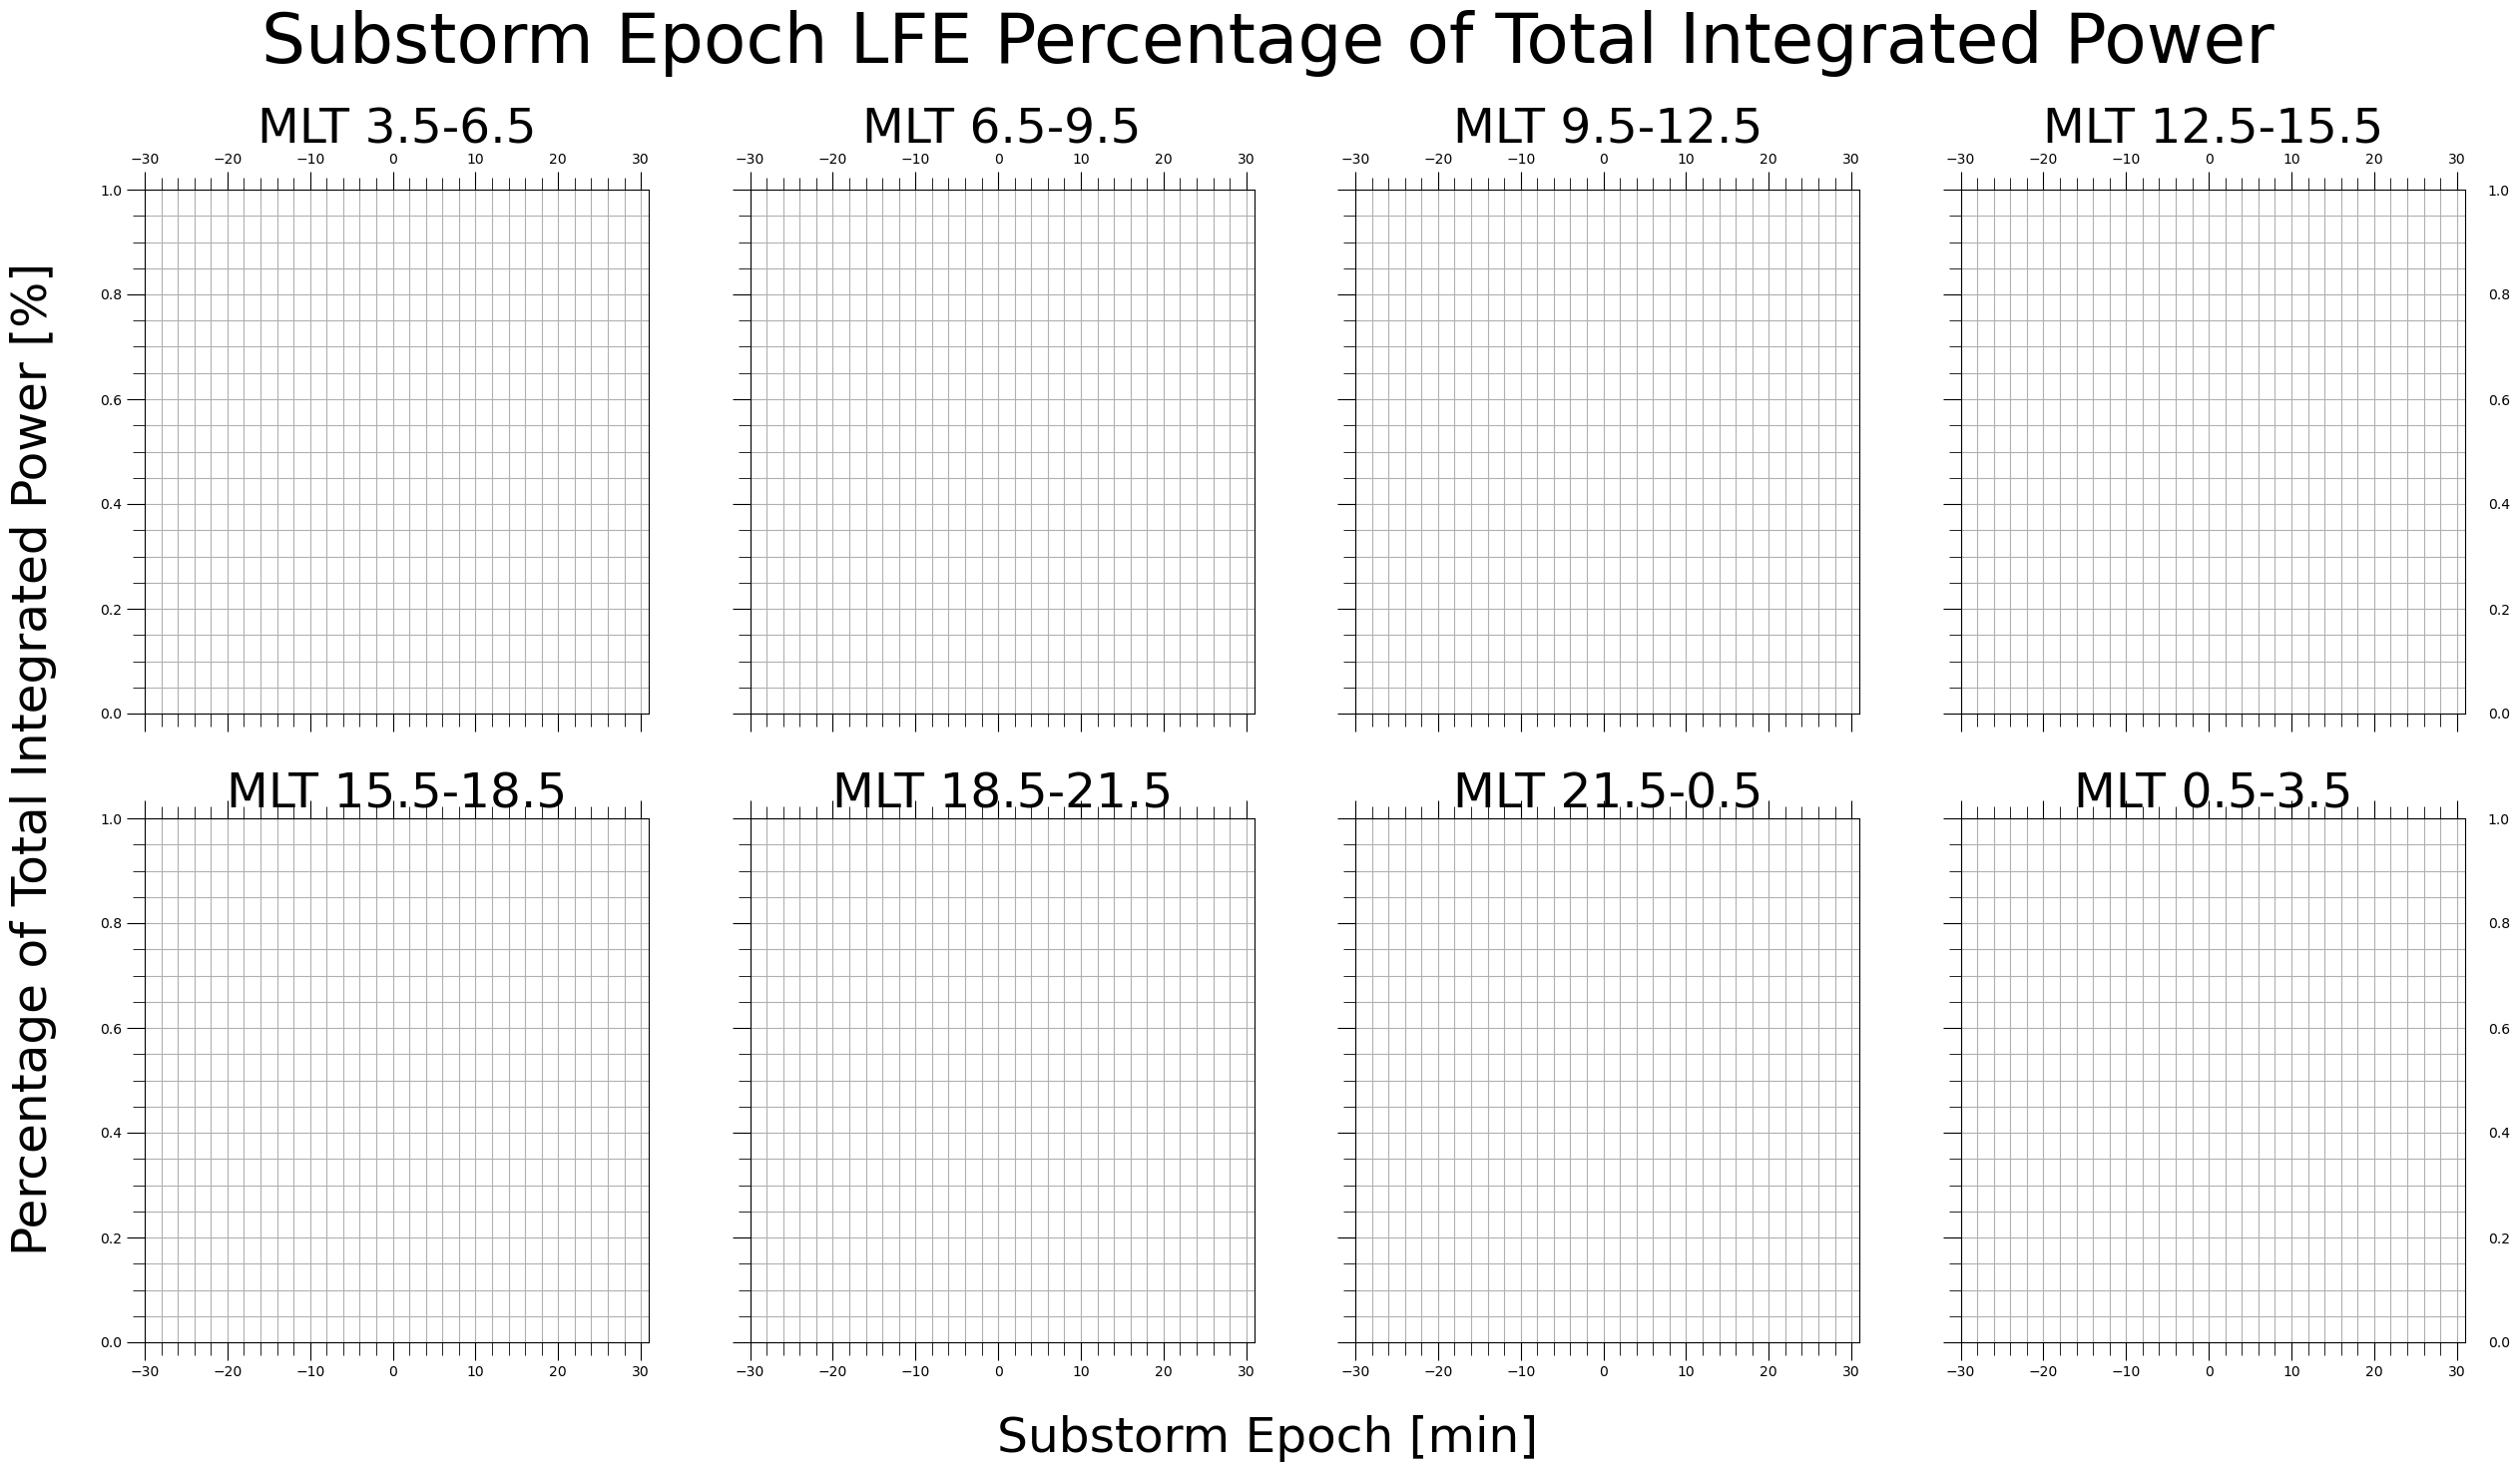

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('tableau-colorblind10')
sub_names= ['Combined', 'Newell', 'Ohtani', 'Sophie']
event_names= ['Combined Imagery', 'Newell and Gjerloev\n(2011)', 'Ohtani and Gjerloev\n(2020)', 'SOPHIE']

# mlt_bins= np.arange(0, 25, 2)
# top_row = range(4, 11, 2), range(6, 13, 2)
# middle_row= range(12, 19, 2), range(14, 21, 2)
# bottom_row= [20, 22, 0, 2], [22, 24, 2, 4]

mlt_bins= np.arange(.5, 25.5, 3)

t_bins= np.arange(-30, 30+183/60, 183/60)
# t_bins= np.arange(-30, 60+183/60, 183/60)

top_row= np.arange(3.5, 15.5, 3), np.arange(6.5, 18.5, 3)
middle_row= [], []
# middle_row= np.arange(9.5, 18.5, 3), np.arange(12.5, 21.5, 3)
bottom_row= [15.5, 18.5, 21.5, .5],  [18.5, 21.5, .5, 3.5]

fig, axes= plt.subplots(int(24/(3*len(bottom_row[0]))), len(bottom_row[0]), sharex=True, sharey=True, figsize=(30, 15), gridspec_kw={'wspace': 0.2})

for ax in axes.flatten():
    ax.set_xlim(t_bins.min(), t_bins.max())
    ax.set_xticks(np.arange(t_bins.min(), t_bins.max(), 10))
    ax.tick_params(axis='both', size=13, which='major')
    ax.tick_params(axis='both', size=9, which='minor')
    ax.minorticks_on()
    ax.grid(which='both')

axes= {f'{mlt1}-{mlt2-24 if mlt2 > 24 else mlt2}': ax for mlt1, mlt2, ax in zip(*np.concatenate((top_row, middle_row, bottom_row), axis=1),
                                                      axes.flatten())}
fig.suptitle(f'Substorm Epoch LFE Percentage of Total Integrated Power', size=50, y=1)

for i, (mlt1, mlt2) in enumerate(zip(*top_row)):
    axes[f'{mlt1}-{mlt2}'].set_title(f'MLT {mlt1}-{mlt2}', size=35)
    if i == len(top_row[0]) - 1:
        axes[f'{mlt1}-{mlt2}'].tick_params(which='both', labeltop=True, labelbottom=False, top=True, bottom=True, labelright=True)
    else:
        axes[f'{mlt1}-{mlt2}'].tick_params(which='both', labeltop=True, labelbottom=False, top=True, bottom=True)

for i, (mlt1, mlt2) in enumerate(zip(*middle_row)):
    axes[f'{mlt1}-{mlt2}'].set_title(f'MLT {mlt1}-{mlt2}', size=35)
    if i == len(middle_row[0]) - 1:
        axes[f'{mlt1}-{mlt2}'].tick_params(which='both', labeltop=False, labelbottom=False, top=True, bottom=True, labelright=True)
    else:
        axes[f'{mlt1}-{mlt2}'].tick_params(which='both', labeltop=False, labelbottom=False, top=True, bottom=True)

for i, (mlt1, mlt2) in enumerate(zip(*bottom_row)):
    axes[f'{mlt1}-{mlt2}'].set_title(f'MLT {mlt1}-{mlt2}', size=35)
    if i == len(bottom_row[0]) - 1:
        axes[f'{mlt1}-{mlt2}'].tick_params(which='both', labeltop=False, labelbottom=True, top=True, bottom=True, labelright=True)
    else:
        axes[f'{mlt1}-{mlt2}'].tick_params(which='both', labeltop=False, labelbottom=True, top=True, bottom=True)

# axes[f'{middle_row[0][0]}-{middle_row[1][0]}'].set_ylabel('Percentage of Total Integrated Power [%]', size=35)
fig.supylabel('Percentage of Total Integrated Power [%]', size=35, x=.08)
fig.supxlabel('Substorm Epoch [min]', size=35, y=.03)
# axes[f'{bottom_row[0][1]}-{bottom_row[1][1]}'].set_xlabel('Substorm Epoch [min]', x=1.1, size=35)

In [ ]:
import pandas as pd
sub_name= sub_names[0]
event_name= event_names[0]
flims= pd.read_csv(f'../Example_Data/LFE_Flims_{sub_name}.csv', parse_dates=['Date_UTC'])
flims['Epoch']= pd.to_timedelta(flims['Epoch'])

FileNotFoundError: [Errno 2] No such file or directory: '../Example_Data/LFE_Flims_Combined.csv'

## Add WIND Location

In [ ]:
import matplotlib.dates as mdates
import vaex as vx
position=vx.open('/home/simon/Documents/WIND_Data/position/1994_2010_vx.hdf5')

def interps(x, *args):
    """
    Create interpolation functions for given arrays.

    Parameters
    ----------
    x : np.ndarray
        The x-values for interpolation.
    *args : np.ndarray
        Arrays to interpolate.

    Returns
    -------
    list of interp1d
        List of interpolation functions.
    """
    from scipy.interpolate import interp1d
    return [interp1d(x, arg, fill_value="extrapolate") for arg in args]

position_funcs= interps(mdates.date2num(position.Date_UTC.values),
                            position.radius.values,
                            position.mlt.values,
                            position.mlat.values)

for col, func in zip(['R', 'MLT', 'MLAT'], position_funcs):
    flims[col]= func(mdates.date2num((flims.Date_UTC.values)))
MLT= flims.MLT.values
MLT[MLT<mlt_bins.max()-24]=MLT[MLT<mlt_bins.max()-24]+24
flims['MLT']= MLT

## Load Integrated Power and Calculate Percentage

In [ ]:
df_int= pd.read_hdf('../Example_Data/extension_integration.hdf5', key=f'integrated_power_{sub_name}_LFE').\
        merge(pd.read_hdf('../Example_Data/extension_integration.hdf5', key=f'integrated_power_{sub_name}_all'),
              on='SWEEP')
df_int= df_int.merge(flims, on='SWEEP')
df_int.sort_values('Date_UTC', inplace=True)
df_int['Epoch']= df_int.Epoch.values.astype('timedelta64[ns]').astype('float64')/(1e9*60)
df_int['Percentage_Power']= (df_int['integral_variable_limits']/df_int['integral_0_1040'])*100
df_int['valid']= df_int.Percentage_Power>0

## Plot Percentage Power

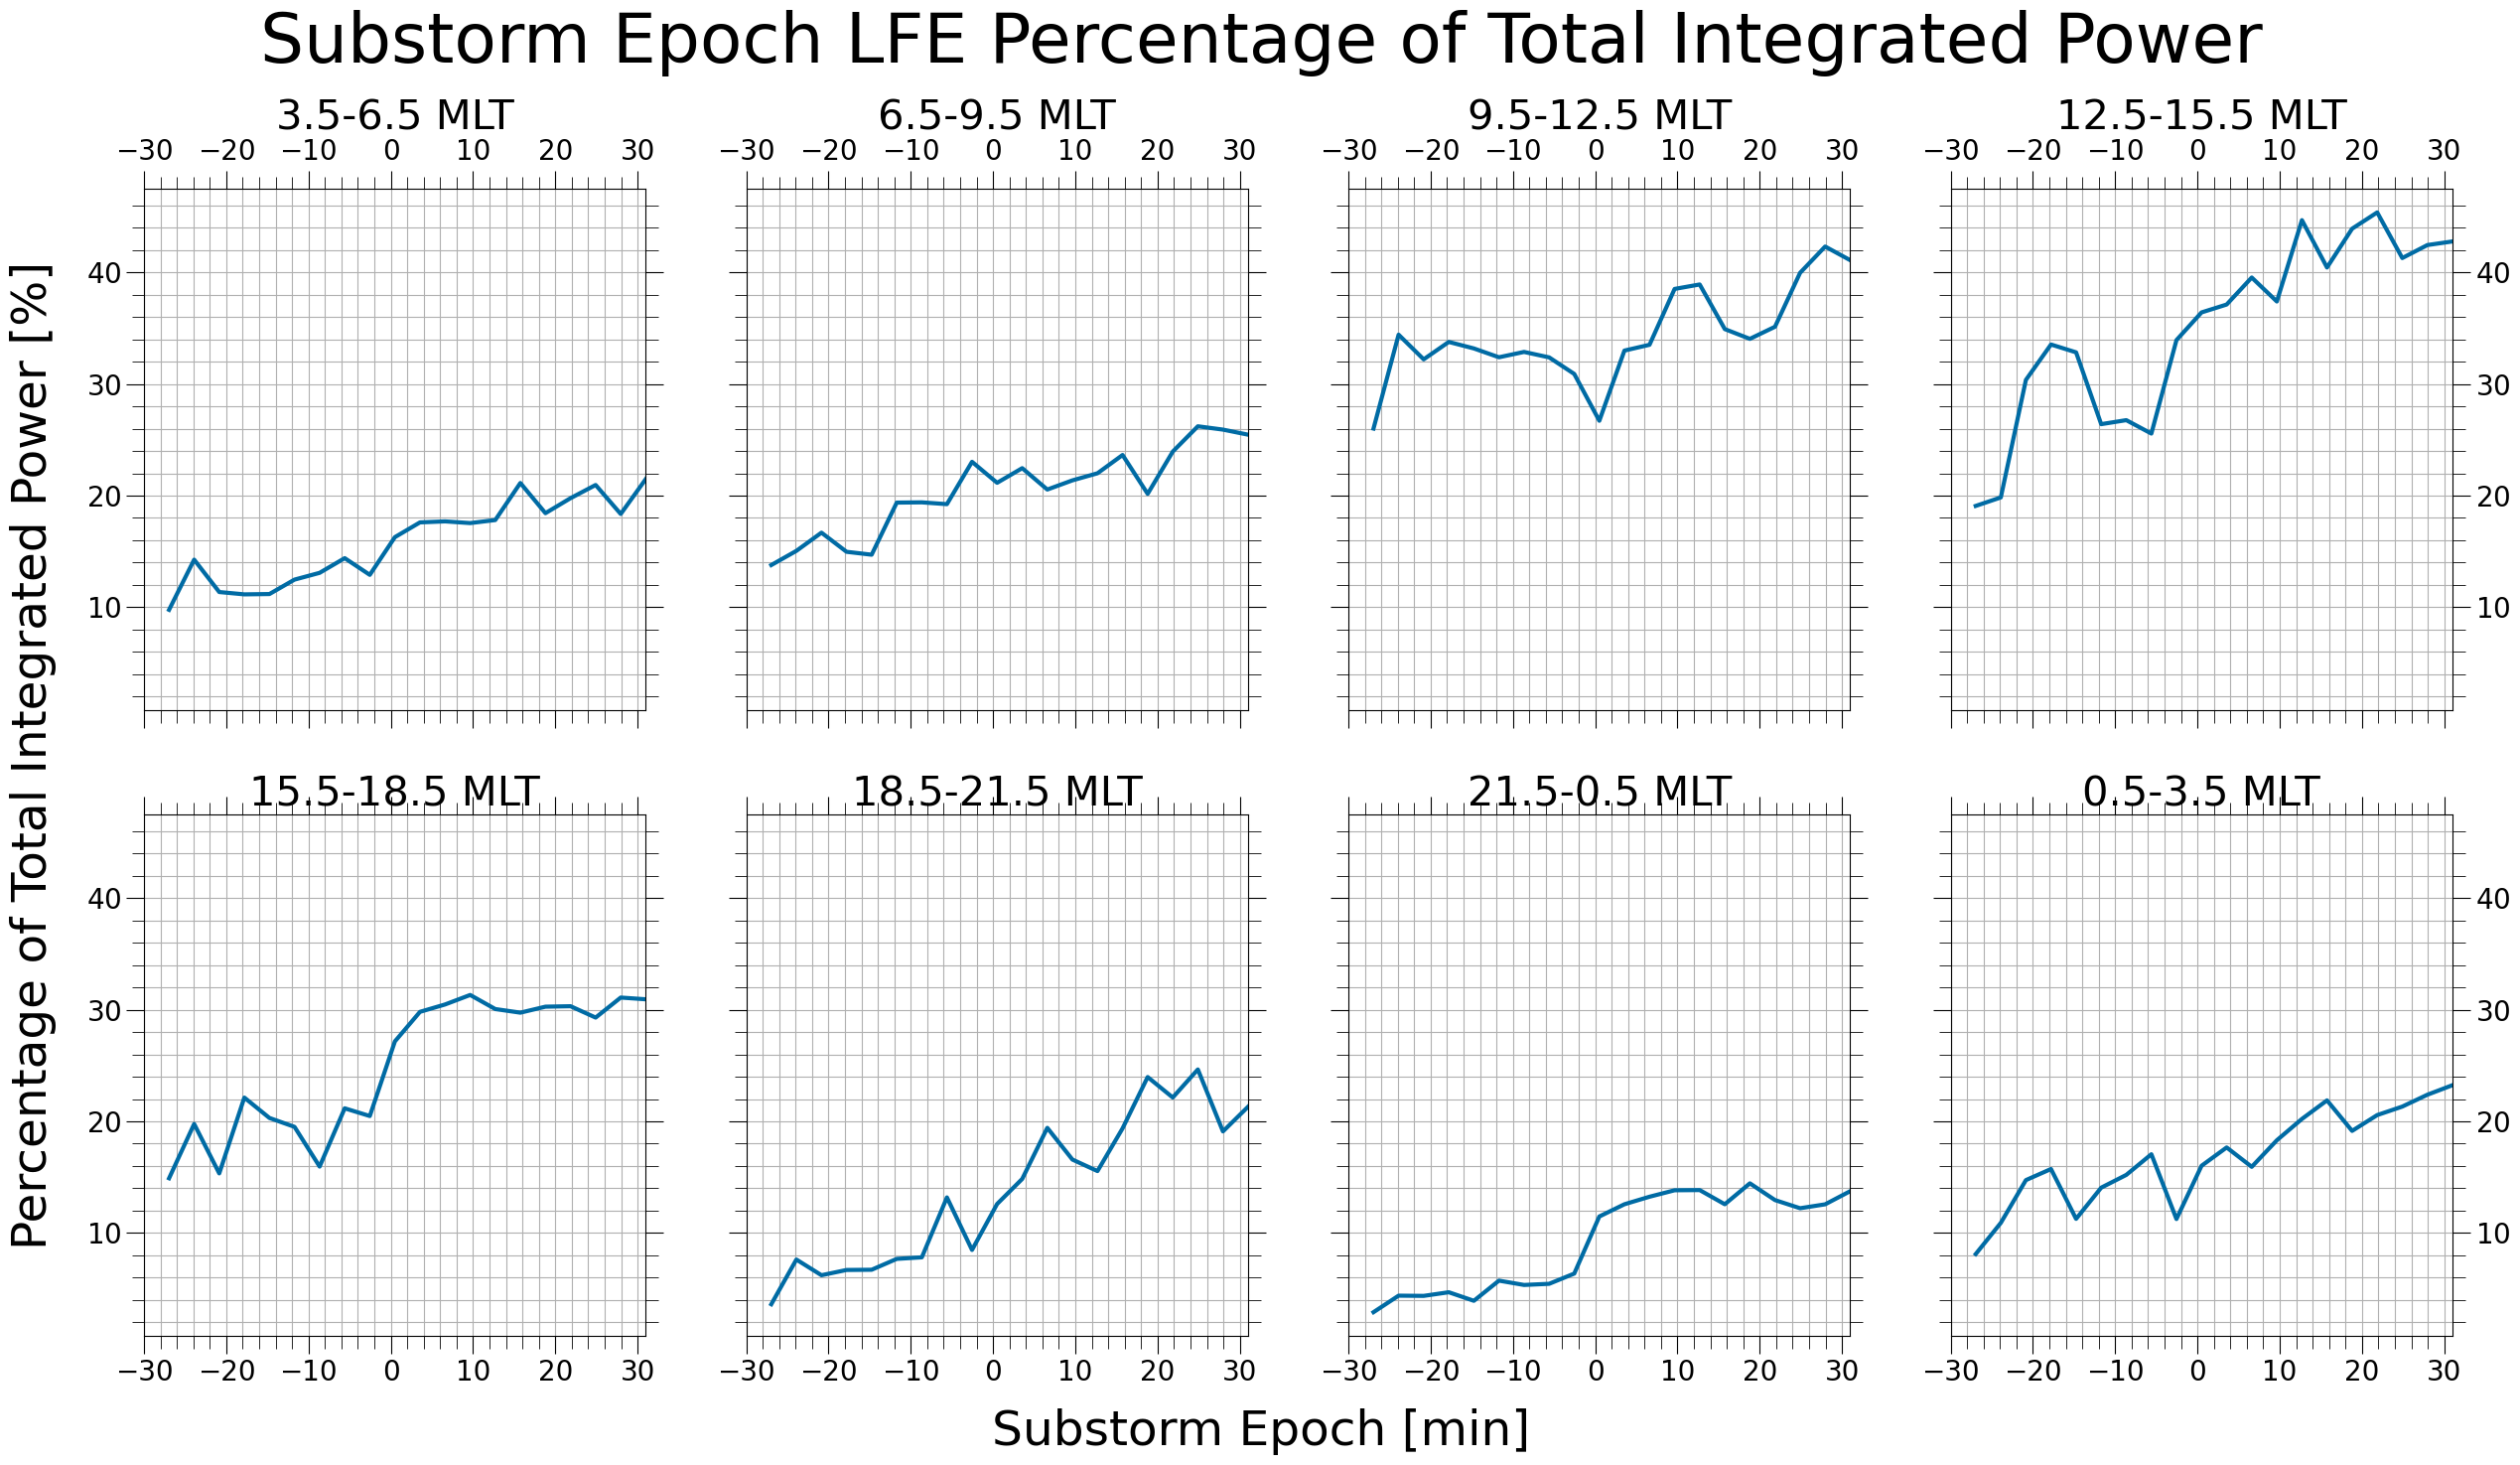

In [ ]:
color= plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
int_pwr= df_int.groupby([pd.cut(df_int.MLT, bins=mlt_bins),
                pd.cut(df_int.Epoch, bins=t_bins)], observed=False)\
                    .Percentage_Power.mean().values
counts= df_int.groupby([pd.cut(df_int.MLT, bins=mlt_bins),
                pd.cut(df_int.Epoch, bins=t_bins)], observed=False)\
                    .valid.sum().values
for val, c, mlt1, mlt2 in zip(int_pwr.reshape(len(mlt_bins)-1,
                                               len(t_bins)-1),
                              counts.reshape(len(mlt_bins)-1,
                                             len(t_bins)-1),
                                               mlt_bins[:-1], mlt_bins[1:]):
    c= sum(c)
    if mlt2 >24:
        mlt2-=24
    ax= axes[f'{mlt1}-{mlt2}']
    if ax is axes[f'{bottom_row[0][2]}-{bottom_row[1][2]}']:
        label_name=event_name+f'\n#LFEs {c}'
    else:
        label_name= f'#LFEs {c}'

    ax.plot(t_bins[:-1]+np.diff(t_bins), val, color=color, label=label_name, lw=3)
    ax.set_title(f'{mlt1}-{mlt2} MLT', size=30)
    ax.minorticks_on()
    # ax.spines[['left']].set_color(color)
    ax.ticklabel_format(axis='y', useMathText=True)
    ax.tick_params(which='both', axis='both', labelsize=20, right=True)
    # ax.grid(axis='x')
    

fig

In [ ]:
import pandas as pd
sub_name= sub_names[1]
event_name= event_names[1]
flims= pd.read_csv(f'../Example_Data/LFE_Flims_{sub_name}.csv', parse_dates=['Date_UTC'])
flims['Epoch']= pd.to_timedelta(flims['Epoch'])

## Add WIND Location

In [ ]:
import matplotlib.dates as mdates
import vaex as vx
position=vx.open('/home/simon/Documents/WIND_Data/position/1994_2010_vx.hdf5')

def interps(x, *args):
    """
    Create interpolation functions for given arrays.

    Parameters
    ----------
    x : np.ndarray
        The x-values for interpolation.
    *args : np.ndarray
        Arrays to interpolate.

    Returns
    -------
    list of interp1d
        List of interpolation functions.
    """
    from scipy.interpolate import interp1d
    return [interp1d(x, arg, fill_value="extrapolate") for arg in args]

position_funcs= interps(mdates.date2num(position.Date_UTC.values),
                            position.radius.values,
                            position.mlt.values,
                            position.mlat.values)

for col, func in zip(['R', 'MLT', 'MLAT'], position_funcs):
    flims[col]= func(mdates.date2num((flims.Date_UTC.values)))
MLT= flims.MLT.values
MLT[MLT<mlt_bins.max()-24]=MLT[MLT<mlt_bins.max()-24]+24
flims['MLT']= MLT

## Load Integrated Power and Calculate Percentage

In [ ]:
df_int= pd.read_hdf('../Example_Data/extension_integration.hdf5', key=f'integrated_power_{sub_name}_LFE').\
        merge(pd.read_hdf('../Example_Data/extension_integration.hdf5', key=f'integrated_power_{sub_name}_all'),
              on='SWEEP')
df_int= df_int.merge(flims, on='SWEEP')
df_int.sort_values('Date_UTC', inplace=True)
df_int['Epoch']= df_int.Epoch.values.astype('timedelta64[ns]').astype('float64')/(1e9*60)
df_int['Percentage_Power']= (df_int['integral_variable_limits']/df_int['integral_0_1040'])*100
df_int['valid']= df_int.Percentage_Power>0

## Plot Percentage Power

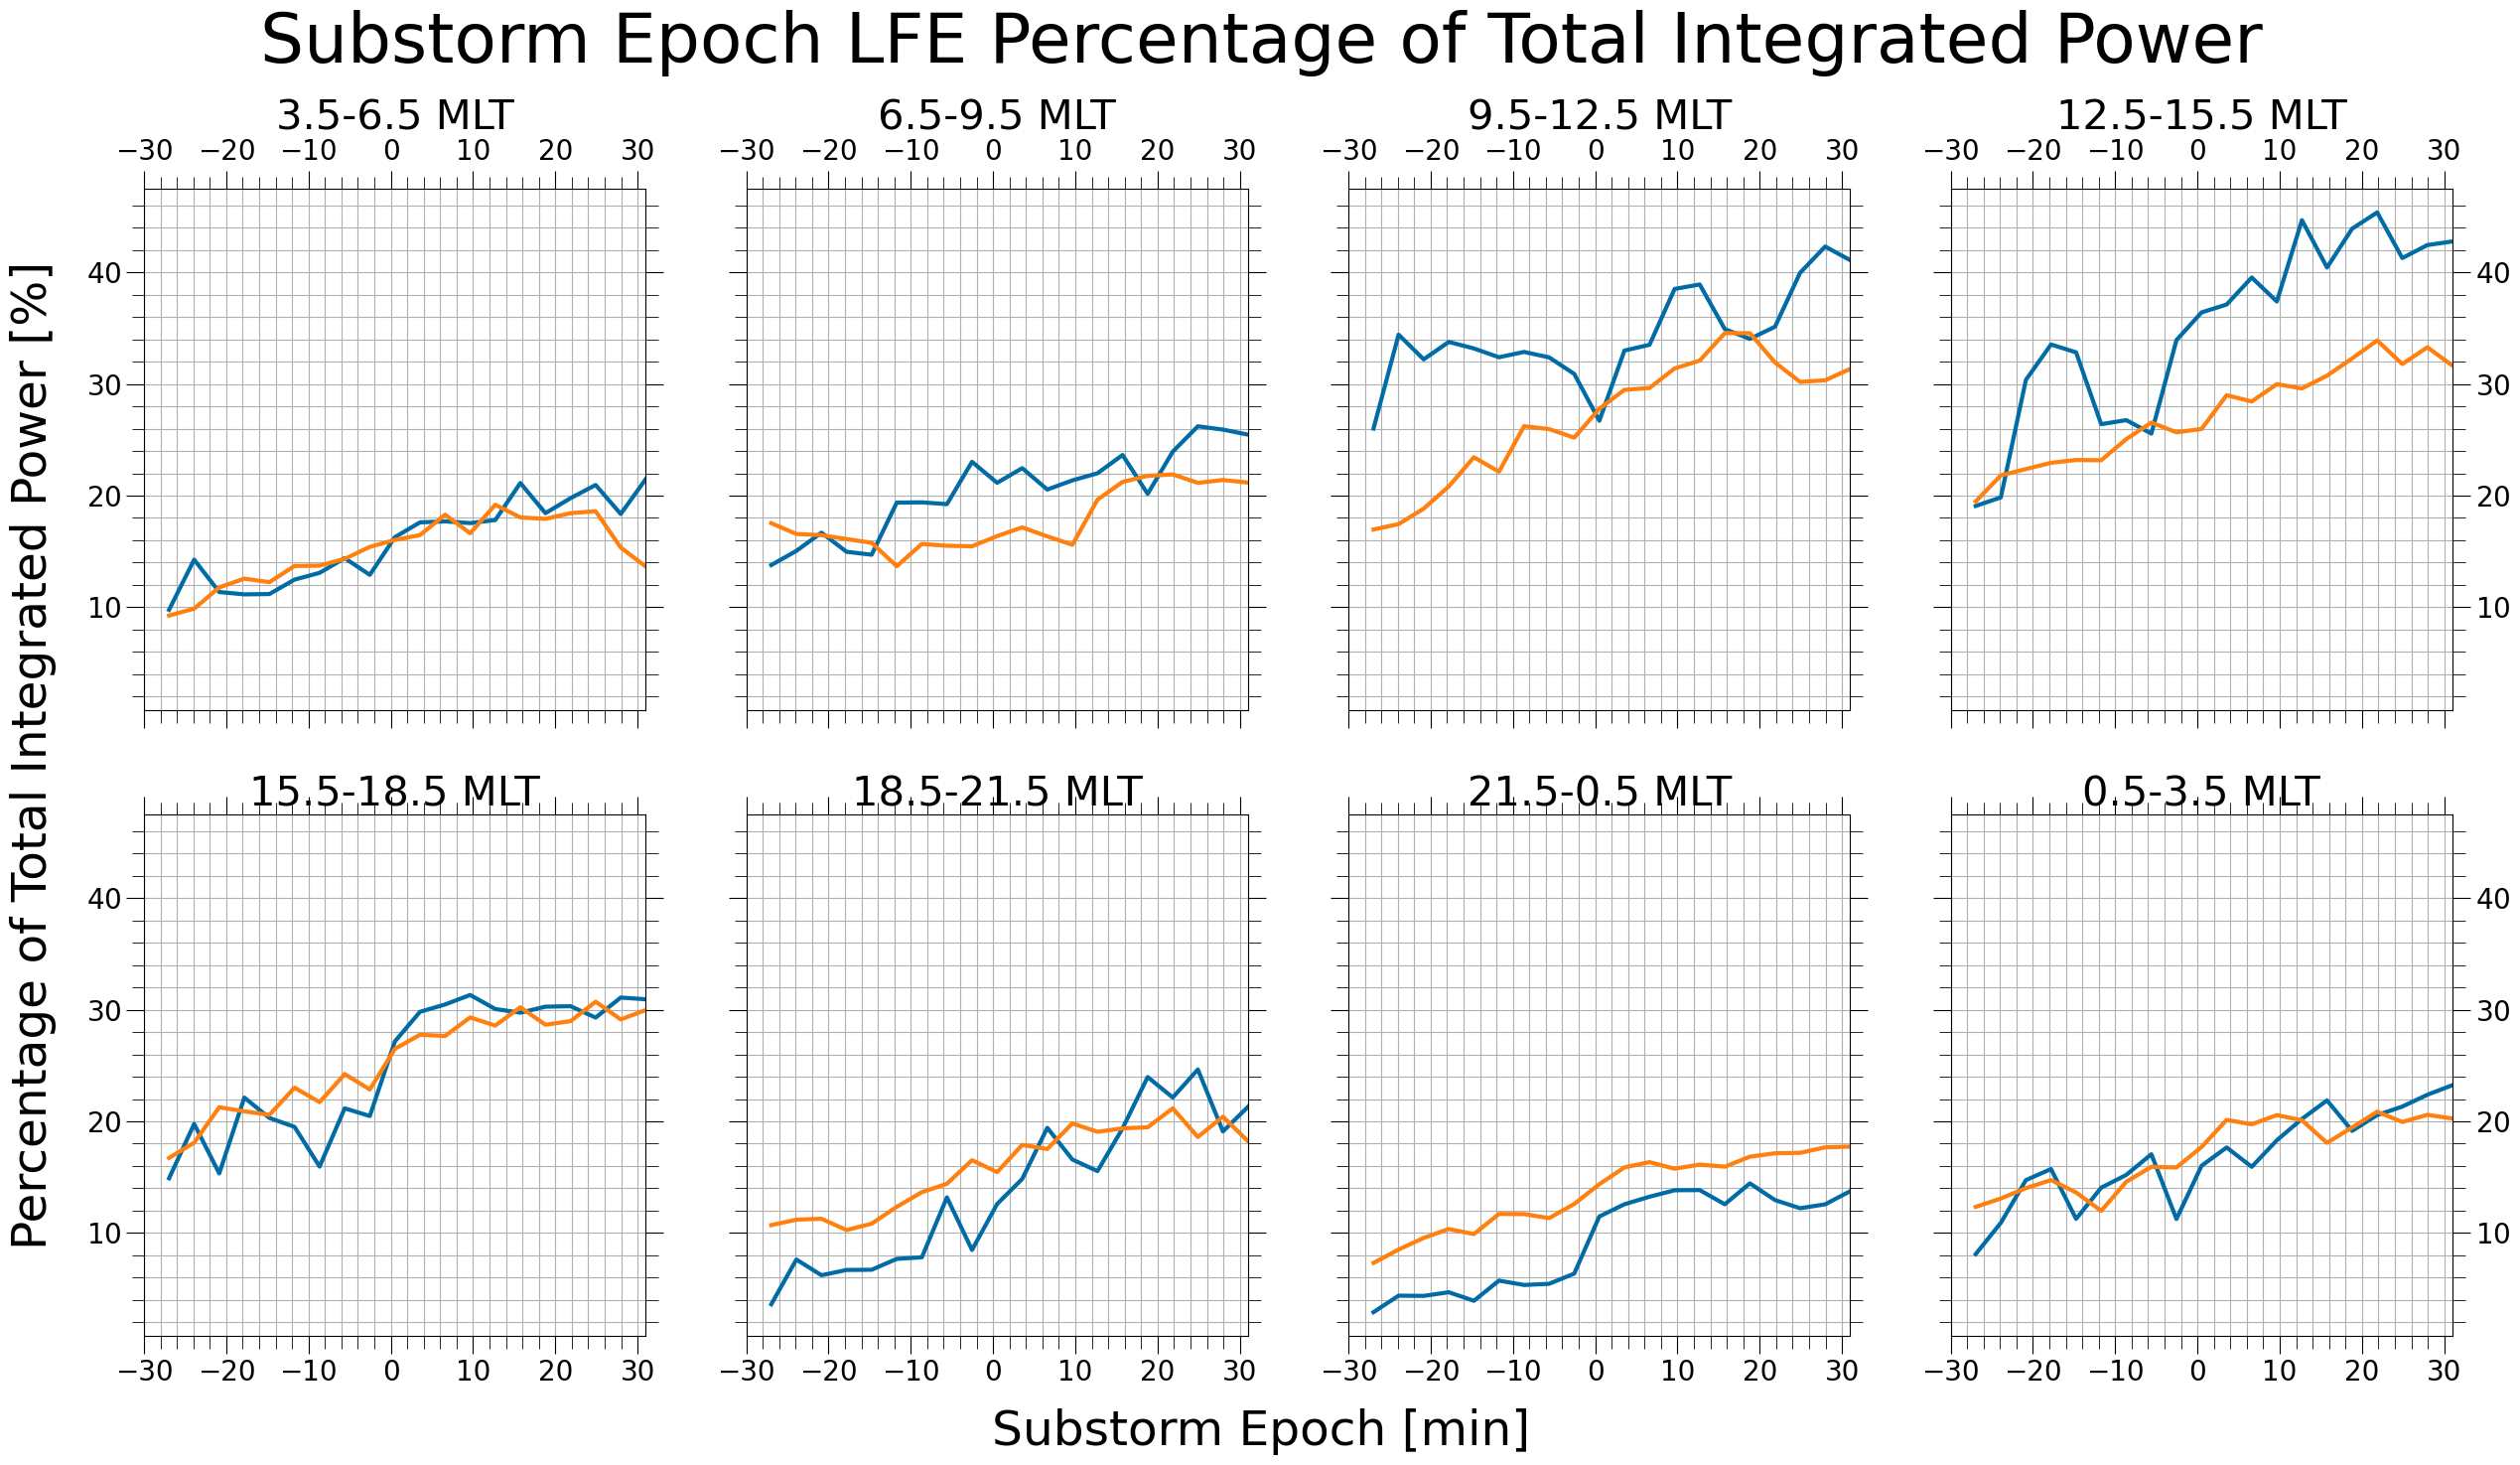

In [ ]:
color= plt.rcParams['axes.prop_cycle'].by_key()['color'][1]

int_pwr= df_int.groupby([pd.cut(df_int.MLT, bins=mlt_bins),
                pd.cut(df_int.Epoch, bins=t_bins)], observed=False)\
                    .Percentage_Power.mean().values
counts= df_int.groupby([pd.cut(df_int.MLT, bins=mlt_bins),
                pd.cut(df_int.Epoch, bins=t_bins)], observed=False)\
                    .valid.sum().values
for val, c, mlt1, mlt2 in zip(int_pwr.reshape(len(mlt_bins)-1,
                                               len(t_bins)-1),
                              counts.reshape(len(mlt_bins)-1,
                                             len(t_bins)-1),
                                               mlt_bins[:-1], mlt_bins[1:]):
    c= sum(c)
    if mlt2 >24:
        mlt2-=24
    ax= axes[f'{mlt1}-{mlt2}']
    if ax is axes[f'{bottom_row[0][2]}-{bottom_row[1][2]}']:
        label_name=event_name+f'\n#LFEs {c}'
    else:
        label_name= f'#LFEs {c}'

    ax.plot(t_bins[:-1]+np.diff(t_bins), val, color=color, label=label_name, lw=3)
    # ax.set_title(f'{mlt1}-{mlt2} MLT', size=30)
    ax.minorticks_on()
    # ax.spines[['left']].set_color(color)
    ax.ticklabel_format(axis='y', useMathText=True)
    ax.tick_params(which='both', axis='both', labelsize=20, right=True)
    # ax.grid(axis='x')
    

fig

In [ ]:
import pandas as pd
sub_name= sub_names[2]
event_name= event_names[2]
flims= pd.read_csv(f'../Example_Data/LFE_Flims_{sub_name}.csv', parse_dates=['Date_UTC'])
flims['Epoch']= pd.to_timedelta(flims['Epoch'])

## Add WIND Location

In [ ]:
import matplotlib.dates as mdates
import vaex as vx
position=vx.open('/home/simon/Documents/WIND_Data/position/1994_2010_vx.hdf5')

def interps(x, *args):
    """
    Create interpolation functions for given arrays.

    Parameters
    ----------
    x : np.ndarray
        The x-values for interpolation.
    *args : np.ndarray
        Arrays to interpolate.

    Returns
    -------
    list of interp1d
        List of interpolation functions.
    """
    from scipy.interpolate import interp1d
    return [interp1d(x, arg, fill_value="extrapolate") for arg in args]

position_funcs= interps(mdates.date2num(position.Date_UTC.values),
                            position.radius.values,
                            position.mlt.values,
                            position.mlat.values)

for col, func in zip(['R', 'MLT', 'MLAT'], position_funcs):
    flims[col]= func(mdates.date2num((flims.Date_UTC.values)))
MLT= flims.MLT.values
MLT[MLT<mlt_bins.max()-24]=MLT[MLT<mlt_bins.max()-24]+24
flims['MLT']= MLT

## Load Integrated Power and Calculate Percentage

In [ ]:
df_int= pd.read_hdf('../Example_Data/extension_integration.hdf5', key=f'integrated_power_{sub_name}_LFE').\
        merge(pd.read_hdf('../Example_Data/extension_integration.hdf5', key=f'integrated_power_{sub_name}_all'),
              on='SWEEP')
df_int= df_int.merge(flims, on='SWEEP')
df_int.sort_values('Date_UTC', inplace=True)
df_int['Epoch']= df_int.Epoch.values.astype('timedelta64[ns]').astype('float64')/(1e9*60)
df_int['Percentage_Power']= (df_int['integral_variable_limits']/df_int['integral_0_1040'])*100
df_int['valid']= df_int.Percentage_Power>0

## Plot Percentage Power

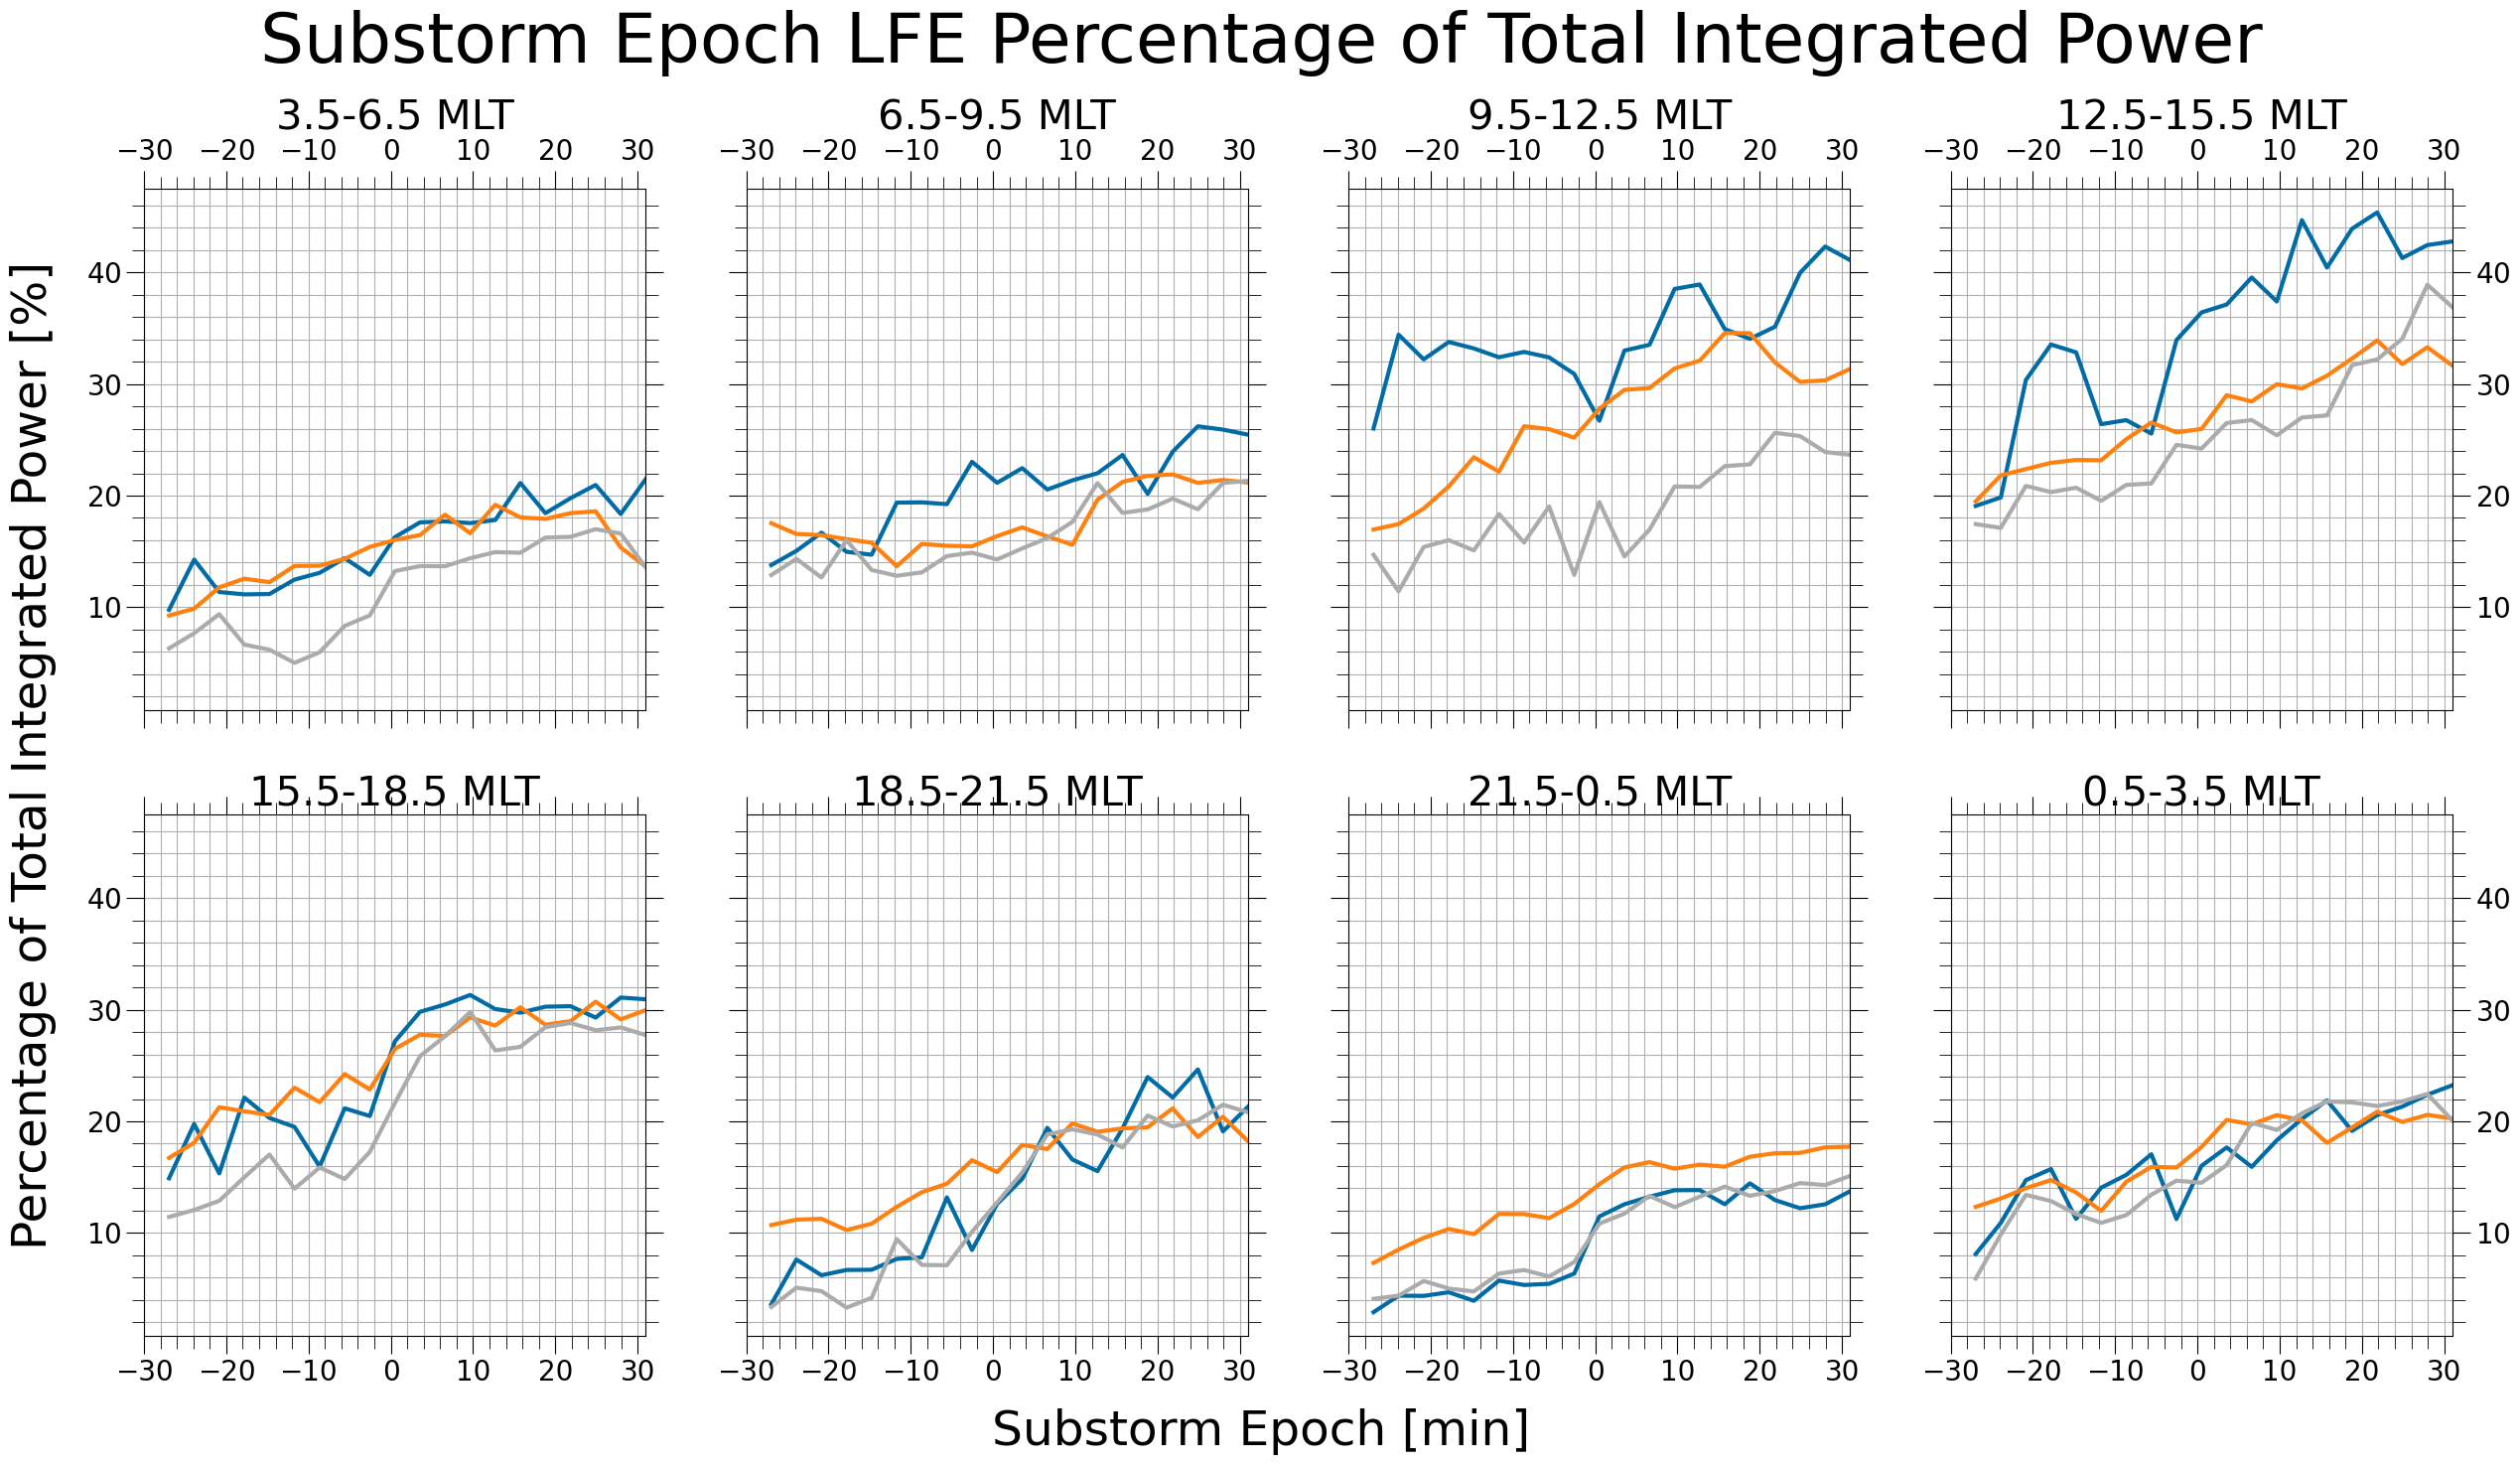

In [ ]:
color= plt.rcParams['axes.prop_cycle'].by_key()['color'][2]

int_pwr= df_int.groupby([pd.cut(df_int.MLT, bins=mlt_bins),
                pd.cut(df_int.Epoch, bins=t_bins)], observed=False)\
                    .Percentage_Power.mean().values
counts= df_int.groupby([pd.cut(df_int.MLT, bins=mlt_bins),
                pd.cut(df_int.Epoch, bins=t_bins)], observed=False)\
                    .valid.sum().values
for val, c, mlt1, mlt2 in zip(int_pwr.reshape(len(mlt_bins)-1,
                                               len(t_bins)-1),
                              counts.reshape(len(mlt_bins)-1,
                                             len(t_bins)-1),                                               
                                               mlt_bins[:-1], mlt_bins[1:]):
    c= sum(c)                                           
    if mlt2 >24:
        mlt2-=24
    ax= axes[f'{mlt1}-{mlt2}']
    if ax is axes[f'{bottom_row[0][2]}-{bottom_row[1][2]}']:
        label_name=event_name+f'\n#LFEs {c}'
    else:
        label_name= f'#LFEs {c}'

    ax.plot(t_bins[:-1]+np.diff(t_bins), val, color=color, label=label_name, lw=3)
    # ax.set_title(f'{mlt1}-{mlt2} MLT', size=30)
    ax.minorticks_on()
    # ax.spines[['left']].set_color(color)
    ax.ticklabel_format(axis='y', useMathText=True)
    ax.tick_params(which='both', axis='both', labelsize=20, right=True)
    # ax.grid(axis='x')
    

fig

In [ ]:
import pandas as pd
sub_name= sub_names[3]
event_name= event_names[3]
flims= pd.read_csv(f'../Example_Data/LFE_Flims_{sub_name}.csv', parse_dates=['Date_UTC'])
flims['Epoch']= pd.to_timedelta(flims['Epoch'])

## Add WIND Location

In [ ]:
import matplotlib.dates as mdates
import vaex as vx
position=vx.open('/home/simon/Documents/WIND_Data/position/1994_2010_vx.hdf5')

def interps(x, *args):
    """
    Create interpolation functions for given arrays.

    Parameters
    ----------
    x : np.ndarray
        The x-values for interpolation.
    *args : np.ndarray
        Arrays to interpolate.

    Returns
    -------
    list of interp1d
        List of interpolation functions.
    """
    from scipy.interpolate import interp1d
    return [interp1d(x, arg, fill_value="extrapolate") for arg in args]

position_funcs= interps(mdates.date2num(position.Date_UTC.values),
                            position.radius.values,
                            position.mlt.values,
                            position.mlat.values)

for col, func in zip(['R', 'MLT', 'MLAT'], position_funcs):
    flims[col]= func(mdates.date2num((flims.Date_UTC.values)))
MLT= flims.MLT.values
MLT[MLT<mlt_bins.max()-24]=MLT[MLT<mlt_bins.max()-24]+24
flims['MLT']= MLT

## Load Integrated Power and Calculate Percentage

In [ ]:
df_int= pd.read_hdf('../Example_Data/extension_integration.hdf5', key=f'integrated_power_{sub_name}_LFE').\
        merge(pd.read_hdf('../Example_Data/extension_integration.hdf5', key=f'integrated_power_{sub_name}_all'),
              on='SWEEP')
df_int= df_int.merge(flims, on='SWEEP')
df_int.sort_values('Date_UTC', inplace=True)
df_int['Epoch']= df_int.Epoch.values.astype('timedelta64[ns]').astype('float64')/(1e9*60)
df_int['Percentage_Power']= (df_int['integral_variable_limits']/df_int['integral_0_1040'])*100
df_int['valid']= df_int.Percentage_Power>0

## Plot Percentage Power

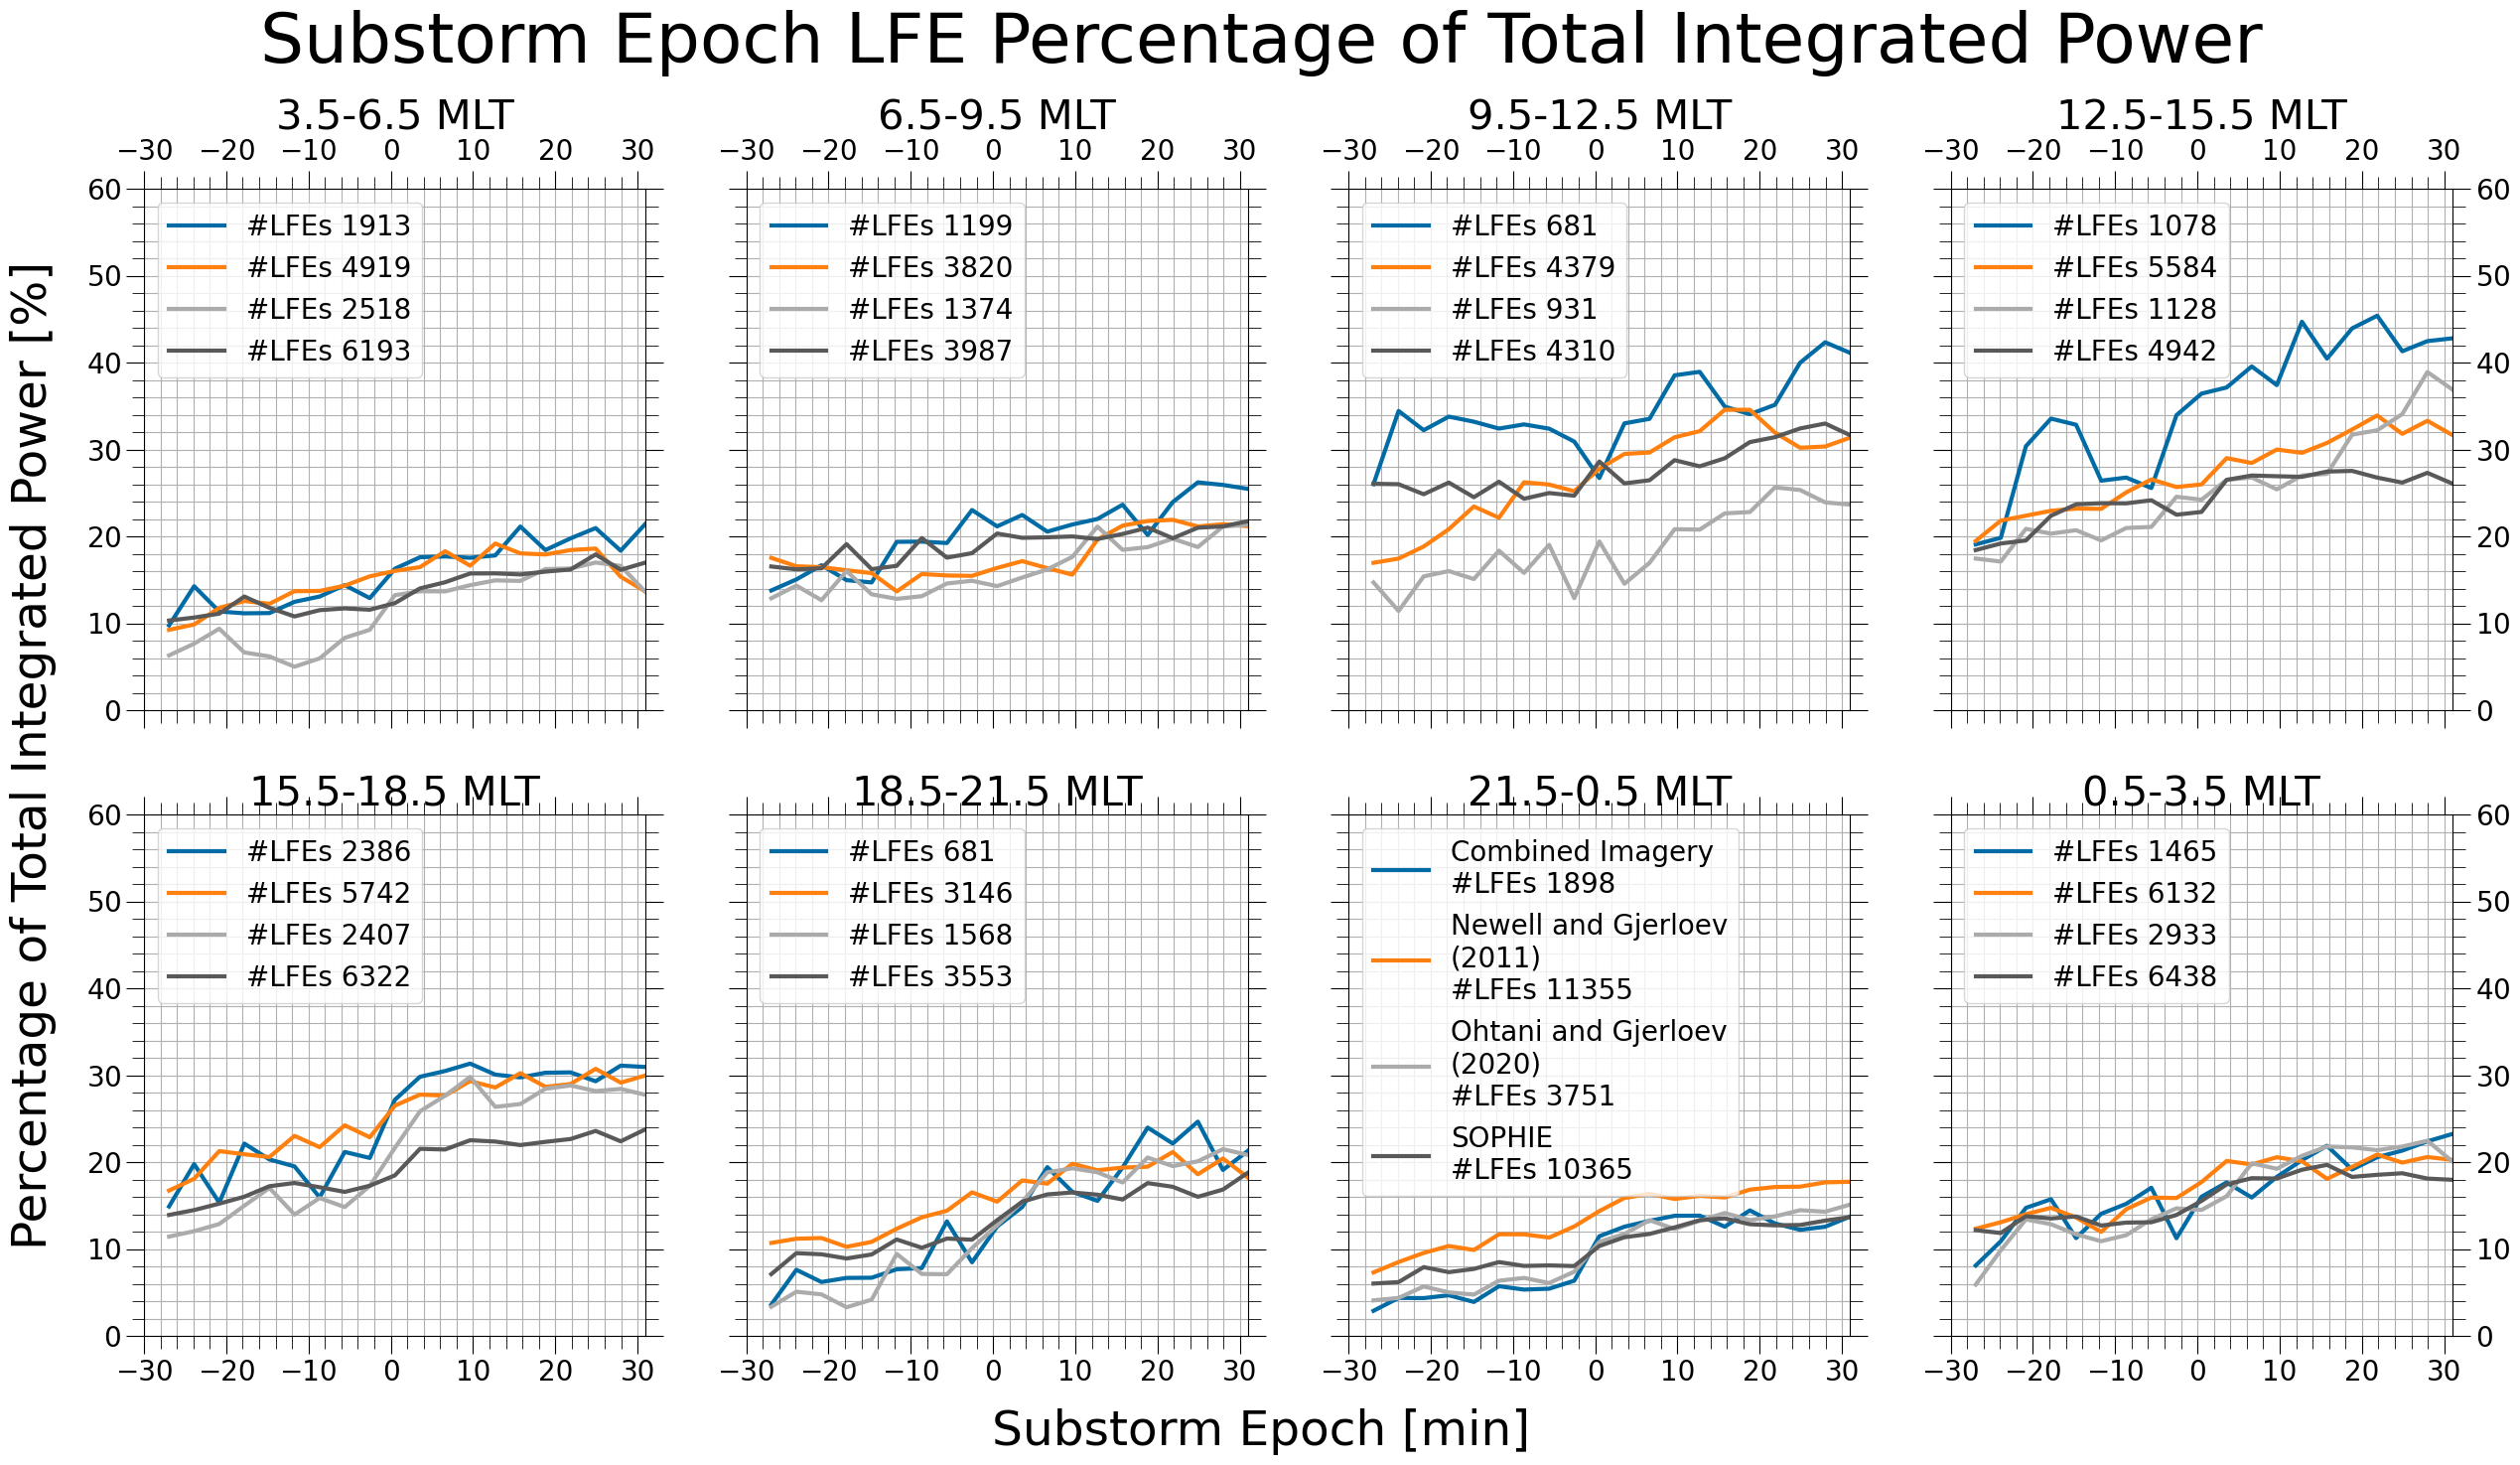

In [ ]:
color= plt.rcParams['axes.prop_cycle'].by_key()['color'][3]

int_pwr= df_int.groupby([pd.cut(df_int.MLT, bins=mlt_bins),
                pd.cut(df_int.Epoch, bins=t_bins)], observed=False)\
                    .Percentage_Power.mean().values
counts= df_int.groupby([pd.cut(df_int.MLT, bins=mlt_bins),
                pd.cut(df_int.Epoch, bins=t_bins)], observed=False)\
                    .valid.sum().values
for val, c, mlt1, mlt2 in zip(int_pwr.reshape(len(mlt_bins)-1,
                                               len(t_bins)-1),
                              counts.reshape(len(mlt_bins)-1,
                                             len(t_bins)-1),                                               
                                               mlt_bins[:-1], mlt_bins[1:]):
    c= sum(c)
    if mlt2 >24:
        mlt2-=24
    ax= axes[f'{mlt1}-{mlt2}']
    if ax is axes[f'{bottom_row[0][2]}-{bottom_row[1][2]}']:
        label_name=event_name+f'\n#LFEs {c}'
    else:
        label_name= f'#LFEs {c}'

    ax.plot(t_bins[:-1]+np.diff(t_bins), val, color=color, label=label_name, lw=3)
    # ax.set_title(f'{mlt1}-{mlt2} MLT', size=30)
    ax.minorticks_on()
    # ax.spines[['left']].set_color(color)
    ax.ticklabel_format(axis='y', useMathText=True)
    ax.tick_params(which='both', axis='both', labelsize=20, right=True)
    # ax.grid(axis='x')
# axes[f'{bottom_row[0][0]}-{bottom_row[1][0]}'].legend(loc='upper left', fontsize=20, frameon=True, ncols=2)
for ax in axes.values():
    ax.legend(loc='upper left', fontsize=20, frameon=True, ncols=1)
ax.set_ylim(0, 60)
fig